In [1]:
## VIDEOACCESS V2

In [ ]:
## EDITED VERSION OF VIDEOACCESs WITH KALMAN

In [31]:
# As a test : when hiding camera, consider the robot moves at a small horizontal speed 

In [32]:
import cv2
import cv2 as cv
from matplotlib import pyplot as plt
import math
from math import atan2, cos, sin, sqrt, pi, degrees
import numpy as np



In [33]:
import numpy as np

# Comments describing Kalman Filter taken from https://stackoverflow.com/questions/74318200/how-to-tune-extended-kalman-filter-on-pykalman

# Example of instance: KF=KalmanFilter(0.03333, [0, 0, 0, 0, 0]) (Ts is time between each measurement, x_ini is initial conditions)

# For update() function : takes as input the measurement vector z
# z[0:2] are the measurements from the camera (px, py, orientation)
# z[3:4] are the measurements from the Thymio (forward speed v and angular speed omega)


class KalmanFilter():
    def __init__(self, Ts, x_ini):
        self.Ts = Ts

        # Initial State Vector
        self.x=np.matrix([[x_ini[0]], [x_ini[1]], [x_ini[2]], [x_ini[3]], [x_ini[4]]])
    

        # State Transition Matrix (Warning : changes with time -> Extended Kalman Filter)
        self.Fk=np.matrix([[1, 0, 0, 0, 0],
                           [0, 1, 0, 0, 0],
                           [0, 0, 1, 0, 0],
                           [0, 0, 0, 1, 0],
                           [0, 0, 0, 0, 1]])

        # Measurement matrix H (here by default, we consider all states px, py, theta, v, omega can be observed)
        # Used to convert the predicted state estimate into predicted sensor measurements at time k.
        # In this case, H will be the identity matrix since the estimated state maps directly to state measurements data
        # H has the same number of rows as sensor measurements and same number of columns as states.
        self.H=np.matrix([[1, 0, 0, 0, 0],
                          [0, 1, 0, 0, 0],
                          [0, 0, 1, 0, 0],
                          [0, 0, 0, 1, 0],
                          [0, 0, 0, 0, 1]])

        
        # State model noise covariance matrix Q
        # When Q is large, the Kalman Filter tracks large changes in
        # the sensor measurements more closely than for smaller Q.
        # Q is a square matrix that has the same number of rows as states.
        self.Q=np.matrix([[0.01, 0, 0, 0, 0],
                          [0, 0.01, 0, 0, 0],
                          [0, 0, 0.01, 0, 0],
                          [0, 0, 0, 0.01, 0],
                          [0, 0, 0, 0, 0.01]]) 

        # Sensor measurement noise covariance matrix R
        # Has the same number of rows and columns as sensor measurements.
        # If we are sure about the measurements, R will be near zero.
        self.R=np.matrix([[0.001, 0, 0, 0, 0],
                          [0, 0.001, 0, 0, 0],
                          [0, 0, 0.001, 0, 0],
                          [0, 0, 0, 0.5, 0],
                          [0, 0, 0, 0, 0.5]])

        self.P=np.matrix([[1, 0, 0, 0, 0],
                           [0, 1, 0, 0, 0],
                           [0, 0, 1, 0, 0],
                           [0, 0, 0, 1, 0],
                           [0, 0, 0, 0, 1]])
        
    def updateFk(self):
        self.Fk=np.matrix([[1, 0, -self.Ts*self.x[3]*np.sin(self.x[2]), self.Ts*np.cos(self.x[2]), 0],
                      [0, 1,  self.Ts*self.x[3]*np.cos(self.x[2]), self.Ts*np.sin(self.x[2]), 0],
                      [0, 0, 1, 0, self.Ts],
                      [0, 0, 0, 1, 0],
                      [0, 0, 0, 0, 1]])
        self.Fk = self.Fk.astype(float)

    def predict(self):
        # Update Fk
        self.updateFk()
        # Predict the state estimate (A Priori) at time k based on the state estimate at time k-1
        self.x=np.dot(self.Fk, self.x)
        # Predict the state covariance estimate based on the previous covariance and some noise
        self.P=np.dot(np.dot(self.Fk, self.P), self.Fk.T)+self.Q
        return self.x

    def update(self, z, CameraAccessible = True): # z[0:2] corrpesonds to measurement of camera, z[3:4] corresponds to measurements of wheels
        
        if CameraAccessible:
            self.H=np.matrix([[1, 0, 0, 0, 0],
                          [0, 1, 0, 0, 0],
                          [0, 0, 1, 0, 0],
                          [0, 0, 0, 1, 0],
                          [0, 0, 0, 0, 1]])
            
            self.R=np.matrix([[0.001, 0, 0, 0, 0],
                          [0, 0.001, 0, 0, 0],
                          [0, 0, 0.001, 0, 0],
                          [0, 0, 0, 0.5, 0],
                          [0, 0, 0, 0, 0.5]])
        else: # CAUTION : IF CAMERAACCESSIBLE = FALSE, Z IS A 2x1 VECTOR
            # Measurement matrix H (now only v and omega can be observed)
            self.H=np.matrix([[0, 0, 0, 1, 0],
                              [0, 0, 0, 0, 1]])
            
            self.R=np.matrix([[0.5, 0],
                              [0,0.5]])
            
            
        # Compute Kalman gain
        S=np.dot(self.H, np.dot(self.P, self.H.T))+self.R
        inv_S = np.linalg.pinv(S.astype(float))
        K=np.dot(np.dot(self.P, self.H.T),inv_S)

        # Correction / innovation
        # Calculate an updated state estimate (A Posteriori) for time k
        self.x=self.x+np.dot(K, (z-np.dot(self.H, self.x)))
        self.x=np.round(self.x.astype(float))
        # Update the state covariance estimate for time k
        I=np.eye(self.H.shape[1])
        self.P=(I-(K*self.H))*self.P


        return self.x

In [34]:
KF=KalmanFilter(0.03333, [0, 0, 0, 0, 0])

fps: 30
Estimated States:
 [[372.]
 [309.]
 [ -0.]
 [  8.]
 [ -2.]]
1
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
Estimated States:
 [[222.]
 [350.]
 [  0.]
 [-19.]
 [ -2.]]
2
Center of Circle: (215, 352)   Angle: 0   Thymio Detected: True
Estimated States:
 [[219.]
 [353.]
 [ -0.]
 [-17.]
 [ -2.]]
3
Center of Circle: (219, 353)   Angle: 0   Thymio Detected: True
Estimated States:
 [[226.]
 [348.]
 [  0.]
 [-13.]
 [ -2.]]
4
Center of Circle: (227, 348)   Angle: 0   Thymio Detected: True
Estimated States:
 [[227.]
 [352.]
 [ -0.]
 [-11.]
 [ -2.]]
5
Center of Circle: (227, 352)   Angle: 0   Thymio Detected: True
Estimated States:
 [[228.]
 [354.]
 [ -0.]
 [ -9.]
 [ -2.]]
6
Center of Circle: (228, 354)   Angle: 0   Thymio Detected: True
Estimated States:
 [[225.]
 [355.]
 [ -0.]
 [ -8.]
 [ -2.]]
7
Center of Circle: (225, 355)   Angle: 0   Thymio Detected: True
Estimated States:
 [[225.]
 [350.]
 [  0.]
 [ -7.]
 [ -2.]]
8
Center of Circle: (225, 350)   Angle: 0   Thymio De

Estimated States:
 [[127.]
 [425.]
 [ -0.]
 [  0.]
 [ -2.]]
66
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
Estimated States:
 [[128.]
 [425.]
 [ -0.]
 [  7.]
 [ -2.]]
67
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
Estimated States:
 [[129.]
 [425.]
 [ -0.]
 [ 13.]
 [ -2.]]
68
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
Estimated States:
 [[130.]
 [425.]
 [ -0.]
 [ 18.]
 [ -2.]]
69
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
Estimated States:
 [[131.]
 [425.]
 [ -0.]
 [ 22.]
 [ -2.]]
70
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
Estimated States:
 [[132.]
 [425.]
 [ -0.]
 [ 26.]
 [ -2.]]
71
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
Estimated States:
 [[133.]
 [425.]
 [ -0.]
 [ 29.]
 [ -2.]]
72
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
Estimated States:
 [[134.]
 [425.]
 [ -0.]
 [ 32.]
 [ -2.]]
73
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
Estimate

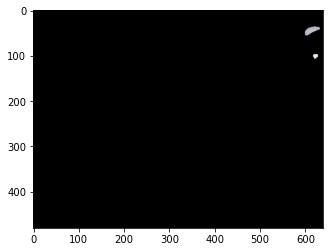

In [36]:
# https://www.geeksforgeeks.org/live-webcam-drawing-using-opencv/

import cv2
import cv2 as cv
from matplotlib import pyplot as plt
import math
from math import atan2, cos, sin, sqrt, pi, degrees
import numpy as np


global center, radius, angle, thymio_detected



# set Width and Height of output Screen
frameWidth = 640
frameHeight = 480
  
# capturing Video from Webcam
cap = cv2.VideoCapture(0)
cap.set(3, frameWidth)
cap.set(4, frameHeight)

# set fps : https://stackoverflow.com/questions/52068277/change-frame-rate-in-opencv-3-4-2
# here does not work
# cap.set(cv2.CAP_PROP_FPS, 10)
fps = int(cap.get(5))
print("fps:", fps)
  
# set brightness, id is 10 and
# value can be changed accordingly
cap.set(10,150)





def get_thymio_position(img, img_output, kalman_center, kalman_angle, min_red = np.array([150, 0, 180]), max_red = np.array([179, 255, 255])):
    
    # RETURNS CENTER COORDINATES, RADIUS AND ORIENTATION (provides extra coordinants (xb, yb) to know which direction, as well as angle) OF THYMIO ROBOT

    
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_hsv_blur = cv2.medianBlur(img_hsv, 15)
    mask = cv2.inRange(img_hsv_blur, min_red, max_red)
    mask = cv2.erode(mask, None, iterations=2) # default 3x3 kernel used
    mask = cv2.dilate(mask, None, iterations=2)    
    output = cv2.bitwise_and(img, img, mask=mask)
    
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE) # cv2.RETR_CCOMP lets us get contours inside parent contours
    contours = sorted(contours, key=lambda x:cv2.contourArea(x), reverse=True)
    
    thymio_detected = False
    center = kalman_center
    radius = 0
    angle = kalman_angle
    
    if len(contours) != 0:

        # find the biggest countour c by the area
        c = max(contours, key = cv2.contourArea)
        if cv.contourArea(c) > 5000:
            thymio_detected = True     

            # Minimum Enclosing Circle :
            (x_circle,y_circle),radius = cv.minEnclosingCircle(c)
            center = (int(x_circle),int(y_circle))
            radius = int(radius)
            cv.circle(output,center,radius,(0,255,0),10)
            cv2.circle(img_output, center, radius, (0,0,255), 10)
            
            # Detection of front of thymio :
            for contour in contours:
                area = cv.contourArea(contour)
                if area > cv2.contourArea(c)/10 and area < cv2.contourArea(c)/10+2000:
                    cv2.drawContours(output ,[contour],-1,(255,255,0),10)
                    (x_front,y_front),radius_front = cv.minEnclosingCircle(contour)
                    center_front = (int(x_front),int(y_front))
                    radius_front = int(radius_front)
                    cv.circle(output,center_front,radius_front,(255,255,0),10)
                    cv2.circle(img_output, center_front, radius_front, (0,255,255), 10)
                    
                    angle = int(degrees(atan2(center_front[1]-center[1],center_front[0]-center[0]))) 
        
            
    plt.imshow(output)
        
    return center, radius, angle, thymio_detected











count = 0

# Check if the webcam is opened correctly
if not cap.isOpened():
    raise IOError("Cannot open webcam")

# running infinite while loop so that
# program keep running until we close it
while True:
    success, img = cap.read()
    imgResult = img.copy()
    
    thymioLoc, thymioRadius, thymioAngle, thymioDetected = get_thymio_position(img, imgResult, (0,0), 0)
    
    
    # KALMAN -------------------------------------------------------------------
    KF.predict()
    if thymioDetected:
        z = np.array([thymioLoc[0],thymioLoc[1],0,0, 0])
        z = np.expand_dims(z, axis=-1)
    else:
        z = np.array([50, -0.1])
        z = np.expand_dims(z, axis=-1)
    KF.update(z,thymioDetected)
    cv2.circle(imgResult, (int(KF.x[0]), int(KF.x[1])), 10, (255,0,255), 10)
    print('Estimated States:\n',KF.x)
    # KALMAN ----------------------------------------------------------------------
    
    count = count +1
    print(count)
    print('Center of Circle:',thymioLoc, '  Angle:',thymioAngle, '  Thymio Detected:' ,thymioDetected)
 

    # displaying output on Screen
    cv2.imshow("Result", imgResult)
    
    c = cv2.waitKey(1)
    if c == 27:
        break
      


In [ ]:
# OLDER VERSION (WITHOUT KALMAN)

In [ ]:
import cv2
import cv2 as cv
from matplotlib import pyplot as plt
import math
from math import atan2, cos, sin, sqrt, pi, degrees
import numpy as np

global center, radius, angle, thymio_detected

cap = cv2.VideoCapture(0)
count = 0

def get_thymio_position(img, kalman_center, kalman_angle, min_red = np.array([150, 0, 180]), max_red = np.array([179, 255, 255])):
    
    # RETURNS CENTER COORDINATES, RADIUS AND ORIENTATION (provides extra coordinants (xb, yb) to know which direction, as well as angle) OF THYMIO ROBOT

    
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_hsv_blur = cv2.medianBlur(img_hsv, 15)
    mask = cv2.inRange(img_hsv_blur, min_red, max_red)
    mask = cv2.erode(mask, None, iterations=2) # default 3x3 kernel used
    mask = cv2.dilate(mask, None, iterations=2)    
    output = cv2.bitwise_and(img, img, mask=mask)
    
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE) # cv2.RETR_CCOMP lets us get contours inside parent contours
    contours = sorted(contours, key=lambda x:cv2.contourArea(x), reverse=True)
    
    thymio_detected = False
    center = kalman_center
    radius = 0
    angle = kalman_angle
    
    if len(contours) != 0:

        # find the biggest countour c by the area
        c = max(contours, key = cv2.contourArea)
        if cv.contourArea(c) > 5000:
            thymio_detected = True     

            # Minimum Enclosing Circle :
            (x_circle,y_circle),radius = cv.minEnclosingCircle(c)
            center = (int(x_circle),int(y_circle))
            radius = int(radius)
            cv.circle(output,center,radius,(0,255,0),10) 
            
            # Detection of front of thymio :
            for contour in contours:
                area = cv.contourArea(contour)
                if area > 2400 and area < 3200:
                    cv2.drawContours(output ,[contour],-1,(255,255,0),10)
                    (x_front,y_front),radius_front = cv.minEnclosingCircle(contour)
                    center_front = (int(x_front),int(y_front))
                    radius_front = int(radius_front)
                    cv.circle(output,center_front,radius_front,(255,255,0),10)
                    
                    angle = int(degrees(atan2(center_front[1]-center[1],center_front[0]-center[0]))) 
        
            
    #plt.imshow(output)
        
    return center, radius, angle, thymio_detected




# Check if the webcam is opened correctly
if not cap.isOpened():
    raise IOError("Cannot open webcam")

while True:
    ret, frame = cap.read()
    frame = cv2.resize(frame, None, fx=1, fy=1, interpolation=cv2.INTER_AREA)
    cv2.imshow('Input', frame)
    thymioLoc, thymioRadius, thymioAngle, thymioDetected = get_thymio_position(frame, (0,0), 0)
    
    cv2.circle(frame, (x, y), radius, (B,G,R), thickness)

    c = cv2.waitKey(1)
    count = count +1
    print(count)
    print('Center of Circle:',thymioLoc, '  Angle:',thymioAngle, '  Thymio Detected:' ,thymioDetected)
    if c == 27:
        break

cap.release()
cv2.destroyAllWindows()